# Load in libraries
Includes some extra stuff from the tutorial that I didn't use

In [426]:
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
from scipy import interpolate
import math 

from parcels import FieldSet,NestedField, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4, DiffusionUniformKh, Variable, Field,GeographicPolar,Geographic, ErrorCode, plotTrajectoriesFile
from datetime import timedelta as delta

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from copy import copy
#import cmocean

## Displacement

Import velocity field of coarse and fine files separately

In [12]:
file_path_coarse = '/Volumes/Seagate Backup Plus Drive/roms_hiig_assim_fc57_7c5b_4801.nc'
file_path_fine = '/Volumes/Seagate Backup Plus Drive/roms_Oahu_Sshore_20210101_20210111.nc'

Make landmask: "land = 1" and "ocean = 0"
Making 2 landmaks, one for fine and one for coarse

In [237]:
def make_landmask(fielddata):
    """Returns landmask where land = 1 and ocean = 0
    fielddata is a netcdf file.
    """
    datafile = Dataset(fielddata)

    landmask = datafile.variables['u'][0, 0]
    landmask = np.ma.masked_invalid(landmask) #remove Nas? 
    landmask = landmask.mask.astype('int')

    return landmask


In [238]:
landmask_coarse = make_landmask(file_path_coarse)
landmask_fine = make_landmask(file_path_fine)
print(landmask_coarse)
print(landmask_fine)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


## Detect the coast
We can detect the edges between land and ocean nodes by computing the Laplacian with the 4 nearest neighbors [i+1,j], [i-1,j], [i,j+1] and [i,j-1]:


∇2landmask=∂xxlandmask+∂yylandmask,

and filtering the positive and negative values. This gives us the location of coast nodes (ocean nodes next to land) and shore nodes (land nodes next to the ocean).

Additionally, we can find the nodes that border the coast/shore diagonally by considering the 8 nearest neighbors, including [i+1,j+1], [i-1,j+1], [i-1,j+1] and [i-1,j-1].

In [239]:
def get_coastal_nodes(landmask):
    """Function that detects the coastal nodes, i.e. the ocean nodes directly
    next to land. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal nodes, the coastal nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype('int')

    return coastal

def get_shore_nodes(landmask):
    """Function that detects the shore nodes, i.e. the land nodes directly
    next to the ocean. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype('int')

    return shore

In [240]:
def get_coastal_nodes_diagonal(landmask):
    """Function that detects the coastal nodes, i.e. the ocean nodes where 
    one of the 8 nearest nodes is land. Computes the Laplacian of landmask
    and the Laplacian of the 45 degree rotated landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal nodes, the coastal nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap += np.roll(landmask, (-1,1), axis=(0,1)) + np.roll(landmask, (1, 1), axis=(0,1))
    mask_lap += np.roll(landmask, (-1,-1), axis=(0,1)) + np.roll(landmask, (1, -1), axis=(0,1))
    mask_lap -= 8*landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype('int')
    
    return coastal
    
def get_shore_nodes_diagonal(landmask):
    """Function that detects the shore nodes, i.e. the land nodes where 
    one of the 8 nearest nodes is ocean. Computes the Laplacian of landmask 
    and the Laplacian of the 45 degree rotated landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap += np.roll(landmask, (-1,1), axis=(0,1)) + np.roll(landmask, (1, 1), axis=(0,1))
    mask_lap += np.roll(landmask, (-1,-1), axis=(0,1)) + np.roll(landmask, (1, -1), axis=(0,1))
    mask_lap -= 8*landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype('int')

    return shore

In [241]:
#make for both coarse and fine 
coastal_coarse = get_coastal_nodes_diagonal(landmask_coarse)
shore_coarse = get_shore_nodes_diagonal(landmask_coarse)
coastal_fine = get_coastal_nodes_diagonal(landmask_fine)
shore_fine = get_shore_nodes_diagonal(landmask_fine)

## Assigning coastal velocities
For the displacement kernel we define a velocity field that pushes the particles back to the ocean. This velocity is a vector normal to the shore.

For the shore nodes directly next to the ocean, we can take the simple derivative of landmask and project the result to the shore array, this will capture the orientation of the velocity vectors.

For the shore nodes that only have a diagonal component, we need to take into account the diagonal nodes also and project the vectors only onto the inside corners that border the ocean diagonally.

Then to make the vectors unitary, we normalize them by their magnitude.

In [242]:
def create_displacement_field(landmask, double_cell=False):
    """Function that creates a displacement field 1 m/s away from the shore.

    - landmask: the land mask dUilt using `make_landmask`.
    - double_cell: Boolean for determining if you want a double cell.
      Default set to False.

    Output: two 2D arrays, one for each camponent of the velocity.
    """
    shore = get_shore_nodes(landmask)
    shore_d = get_shore_nodes_diagonal(landmask) # bordering ocean directly and diagonally
    shore_c = shore_d - shore                    # corner nodes that only border ocean diagonally
    
    Ly = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0) # Simple derivative
    Lx = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
    
    Ly_c = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
    Ly_c += np.roll(landmask, (-1,-1), axis=(0,1)) + np.roll(landmask, (-1,1), axis=(0,1)) # Include y-component of diagonal neighbours
    Ly_c += - np.roll(landmask, (1,-1), axis=(0,1)) - np.roll(landmask, (1,1), axis=(0,1))
    
    Lx_c = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
    Lx_c += np.roll(landmask, (-1,-1), axis=(1,0)) + np.roll(landmask, (-1,1), axis=(1,0)) # Include x-component of diagonal neighbours
    Lx_c += - np.roll(landmask, (1,-1), axis=(1,0)) - np.roll(landmask, (1,1), axis=(1,0))
    
    v_x = -Lx*(shore)
    v_y = -Ly*(shore)
    
    v_x_c = -Lx_c*(shore_c)
    v_y_c = -Ly_c*(shore_c)
    
    v_x = v_x + v_x_c
    v_y = v_y + v_y_c

    magnitude = np.sqrt(v_y**2 + v_x**2)
    # the coastal nodes between land create a problem. Magnitude there is zero
    # I force it to be 1 to avoid problems when normalizing.
    ny, nx = np.where(magnitude == 0)
    magnitude[ny, nx] = 1

    v_x = v_x/magnitude
    v_y = v_y/magnitude

    return v_x, v_y

In [243]:
#again make for coarse and fine 
v_x_c, v_y_c = create_displacement_field(landmask_coarse)
v_x_f, v_y_f = create_displacement_field(landmask_fine)


In [42]:
np.sum((v_x_c))

8.213203435596423

## Calculate the distance to the shore
In this tutorial, we will only displace particles that are within some distance (smaller than the grid size) to the shore.

For this we map the distance of the coastal nodes to the shore: Coastal nodes directly neighboring the shore are 1dx away. Diagonal neighbors are 2‾√dx away. The particles can then sample this field and will only be displaced when closer than a threshold value. This gives a crude estimate of the distance.

In [244]:
def distance_to_shore(landmask, dx=1):
    """Function that computes the distance to the shore. It is based in the
    the `get_coastal_nodes` algorithm.

    - landmask: the land mask dUilt using `make_landmask` function.
    - dx: the grid cell dimension. This is a crude approxsimation of the real
    distance (be careful).

    Output: 2D array containing the distances from shore.
    """
    ci = get_coastal_nodes(landmask) # direct neighbours
    dist = ci*dx                     # 1 dx away
    
    ci_d = get_coastal_nodes_diagonal(landmask) # diagonal neighbours
    dist_d = (ci_d - ci)*np.sqrt(2*dx**2)       # sqrt(2) dx away
        
    return dist+dist_d

In [245]:
#make for both coarse and fine 
d_2_s_c = distance_to_shore(landmask_coarse)
d_2_s_f = distance_to_shore(landmask_fine)

## Particle and Kernels
The distance to shore, used to flag whether a particle must be displaced, is stored in a particle Variable d2s. To visualize the displacement, the zonal and meridional displacements are stored in the variables dU and dV.

To write the displacement vector to the output before displacing the particle, the set_displacement kernel is invoked after the advection kernel. Then only in the next timestep are particles displaced by displace, before resuming the advection.

need a way to tell it to use fieldset.distance2shore_fine/fieldset.dispUF/fieldset.dispVF versus fieldset.distance2shore_coarse/fieldset.dispUC/fieldset.dispVC

In [441]:
#myDat1.latitude.coords
#min(myDat1.longitude)
#print(min(myDat2.longitude))
#print(min(myDat1.latitude))
#print(min(myDat2.latitude))
#read in as constant fieldset like we did w/ PLD 
fine_lon_range = [-158.1218, -157.7903]
coarse_lon_range = [-163.8307, -152.5193]
fine_lat_range = [21.23194, 21.32355]
coarse_lat_range = [17.01843, 23.98239]

[17.01843, 23.98239]


In [460]:
fine_lon_range

[-158.1218, -157.7903]

In [471]:
particle = -158.009
particle2 = 21.3
if particle <= -157.7903 and particle >= -158.1218 and particle2 <= 21.32355 and particle2 >= 21.23194: print("hi")

hi


In [472]:
class DisplacementParticle(JITParticle):
    dU = Variable('dU')
    dV = Variable('dV')
    d2s = Variable('d2s', initial=1e3)
    
def set_displacement(particle, fieldset, time):
    #try saying in between max and min 
    
    if  particle.lon <= -157.7903 and particle.lon >= -158.1218 and particle.lat <= 21.32355 and particle.lat >= 21.23194:   
        particle.d2s = fieldset.distance2shore_fine[time, particle.depth,
                               particle.lat, particle.lon]
        if  particle.d2s < 0.5:
            dispUab = fieldset.dispUF[time, particle.depth, particle.lat,
                               particle.lon]
            dispVab = fieldset.dispVF[time, particle.depth, particle.lat,
                               particle.lon]
            
            particle.dU = dispUab
            particle.dV = dispVab
        else:
            particle.dU = 0.
            particle.dV = 0.
    else:
        particle.d2s = fieldset.distance2shore_coarse[time, particle.depth,
                               particle.lat, particle.lon]
    
        if  particle.d2s < 0.5:
            dispUab = fieldset.dispUC[time, particle.depth, particle.lat,
                               particle.lon]
            dispVab = fieldset.dispVC[time, particle.depth, particle.lat,
                               particle.lon]
        

            particle.dU = dispUab
            particle.dV = dispVab
        else:
            particle.dU = 0.
            particle.dV = 0.
    
def displace(particle, fieldset, time):    
    if  particle.d2s < 0.5:
        particle.lon += particle.dU*particle.dt
        particle.lat += particle.dV*particle.dt

## Delete Particle
For when it goes past the boundary 

In [473]:
def DeleteParticle(particle, fieldset, time):
    print('deleted particle')
    particle.delete()

## Simulation
Now let us test the displacement of the particles as they approach the shore.

### Create fieldset

In [28]:
startDate = '2021-01-01'
endDate = '2021-02-11'
simDepth = 4  # this is the depth layer, not the depth
file1 = 'https://pae-paha.pacioos.hawaii.edu/erddap/griddap/roms_hiomsg'
file2 = 'https://pae-paha.pacioos.hawaii.edu/erddap/griddap/roms_hiig_assim'

In [387]:
ds1 = xr.open_dataset(file1)  # this puts the opendap data into a xarray dataset
myDat1 = ds1.isel(**{'depth': simDepth}).sel(**{'time': slice(startDate,endDate)})

ds2 = xr.open_dataset(file2)  # this puts the opendap data into a xarray dataset
myDat2 = ds2.isel(**{'depth': simDepth}).sel(**{'time': slice(startDate,endDate)})

In [389]:
variables = {'U': 'u', 'V': 'v'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}

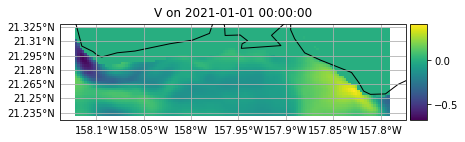

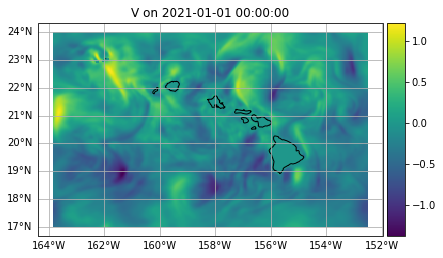

In [480]:
# 1. Generate individual fields
U1=Field.from_xarray(myDat1.u, 'U', dimensions)
V1=Field.from_xarray(myDat1.v, 'V', dimensions)
U2=Field.from_xarray(myDat2.u, 'U', dimensions)
V2=Field.from_xarray(myDat2.v, 'V', dimensions)

# Make sure the fields are read in correctly
V1.show()
V2.show()

# 2. Create nested fields. Make sure the SMALLER domain field is read in FIRST
U = NestedField('U', [U1,U2])
V = NestedField('V', [V1,V2])

# 3. Generate fieldset
fieldset = FieldSet(U, V)

In [481]:
#create u and v displacement for coarse and fine 
u_displacement_c = v_x_c
u_displacement_f = v_x_f
v_displacement_c = v_y_c
v_displacement_f = v_y_f
#fieldset for U fine 
fieldset.add_field(Field('dispUF', data=u_displacement_f,
                         lon=fieldset.U[0].grid.lon, lat=fieldset.U[0].grid.lat,
                         mesh='spherical')) #have to index to choose which field we want to base it off of; 1 is choosing coarser
#fieldset for U coarse
fieldset.add_field(Field('dispUC', data=u_displacement_c,
                         lon=fieldset.U[1].grid.lon, lat=fieldset.U[1].grid.lat,
                         mesh='spherical'))
#fieldset for V fine
fieldset.add_field(Field('dispVF', data=v_displacement_f,
                         lon=fieldset.U[0].grid.lon, lat=fieldset.U[0].grid.lat,
                         mesh='spherical'))
#fieldset for V coarse
fieldset.add_field(Field('dispVC', data=v_displacement_c,
                         lon=fieldset.U[1].grid.lon, lat=fieldset.U[1].grid.lat,
                         mesh='spherical'))

fieldset.dispUF.units = GeographicPolar()
fieldset.dispUC.units = GeographicPolar()
fieldset.dispVF.units = Geographic()
fieldset.dispVC.units = Geographic()

In [482]:
fieldset.add_field(Field('landmask_fine', landmask_fine,
                         lon=fieldset.U[0].grid.lon, lat=fieldset.U[0].grid.lat,
                         mesh='spherical'))

fieldset.add_field(Field('landmask_coarse', landmask_coarse,
                         lon=fieldset.U[1].grid.lon, lat=fieldset.U[1].grid.lat,
                         mesh='spherical'))

fieldset.add_field(Field('distance2shore_fine', d_2_s_f,
                         lon=fieldset.U[0].grid.lon, lat=fieldset.U[0].grid.lat,
                         mesh='spherical'))

fieldset.add_field(Field('distance2shore_coarse', d_2_s_c,
                         lon=fieldset.U[1].grid.lon, lat=fieldset.U[1].grid.lat,
                         mesh='spherical'))

In [483]:
kh = 10   # This is the eddy diffusivity in m2/s

# Add even diffusivity to the fieldset; value of constant field is kh; create field with values of 10? 
fieldset.add_constant_field('Kh_zonal', kh, mesh='spherical')
#zonal follows lat
fieldset.add_constant_field('Kh_meridional', kh, mesh='spherical')   
#meridional follows long 
#mesh=sphererical makes the field match the globe shape rather than a flat shape 

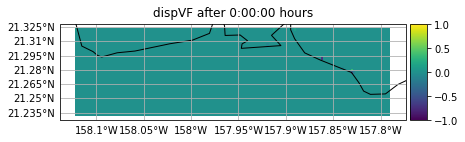

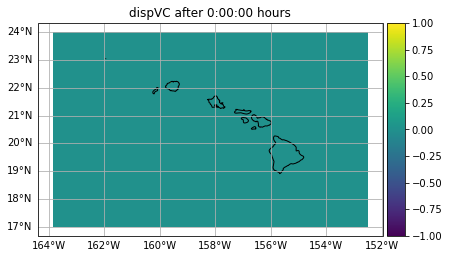

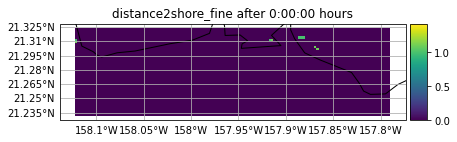

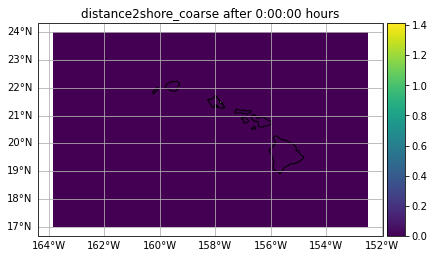

In [484]:
fieldset.dispVF.show()
fieldset.dispVC.show()
fieldset.distance2shore_fine.show()
fieldset.distance2shore_coarse.show()
#these don't look right 

In [485]:
# Set input file
#infile = pd.read_csv('LAPS_release_sites.csv')
nrepeat = 10 #how many times do you want locations to repeat 
# Set the second column as longitude and third column as latitude (remember that python indexing starts at 0!)
infile = pd.read_csv("/Users/gabimukai/Downloads/coord.test_OP.csv", header = None) #read in file I make 

habilon = infile[1] #indicate what column in csv file is lon
habilat = infile[0]
habilon = np.repeat(infile[1],nrepeat) #add repeat if applicable 
habilat = np.repeat(infile[0],nrepeat)
habisite = np.repeat(infile[2],nrepeat)

# Time interval between particle release (in seconds)
release_int = 86400

# Start date for release (if you want it different from the first day of the currents in the fielset)
#start_date = datetime(2000, 1, 16)



# Define the pset
pset = ParticleSet.from_list(fieldset=fieldset, #parameter found in ParticleSet
                             pclass=DisplacementParticle, #parameter found in ParticleSet
                             lon=habilon, #parameter found in ParticleSet
                             lat=habilat, #parameter found in ParticleSet
                             repeatdt=release_int) #parameter found in ParticleSet

kernels = pset.Kernel(displace) + pset.Kernel(AdvectionRK4) + pset.Kernel(DiffusionUniformKh) + pset.Kernel(set_displacement)

output_file = pset.ParticleFile(name="BounceNestedPract2.nc", outputdt=delta(hours=1))
run_days = 10

pset.execute(kernels, runtime=delta(days=run_days), dt=delta(hours=1),recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file=output_file)
output_file.close()

INFO: Compiled DisplacementParticledisplaceAdvectionRK4DiffusionUniformKhset_displacement ==> /var/folders/21/r67h7n991fdb9p8j0tlrp2lm0000gn/T/parcels-501/4bb1f113bf798cff11574cd8916395b0_0.so
INFO: Temporary output files are stored in out-XBQGQDLO.
INFO: You can use "parcels_convert_npydir_to_netcdf out-XBQGQDLO" to convert these to a NetCDF file during the run.
 74% (640800.0 of 864000.0) |########    | Elapsed Time: 0:00:08 ETA:   0:00:07

deleted particle


 94% (813600.0 of 864000.0) |########### | Elapsed Time: 0:00:14 ETA:   0:00:01

deleted particle


100% (864000.0 of 864000.0) |############| Elapsed Time: 0:00:16 Time:  0:00:16
